# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

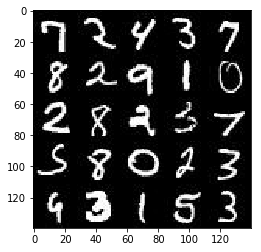

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

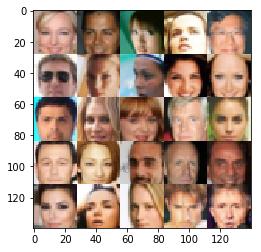

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'image')
    noise = tf.placeholder(tf.float32, (None, z_dim), 'noise')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return (image, noise, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, is_train=True):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: Float for leaky relu activation function
    :param is_train: Boolean if the model is training
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer 28x28x3
        # No batch normalization on first layer as per dcgan lesson
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        # Input layer 2 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        # Input layer 3 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        # Input layer 4 4x4x256
        flattened = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: Float for leaky relu activation function 
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1 fully connected
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha*bn1, bn1)
        
        # Input layer 2 7x7x256
        x2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        # Input layer 3 14x14x128
        x3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha*bn3, bn3)
        
        # Input layer 4 28x28x64
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits) * 0.5
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(g_out, reuse=True)
    
    # Discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [56]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build the model
    out_dim = len(data_image_mode)
    real_inp, z_inp, lr = model_inputs(28, 28, out_dim, z_dim)
    d_loss, g_loss = model_loss(real_inp, z_inp, out_dim)
    d_train, g_train = model_opt(d_loss, g_loss, lr, beta1)
    
    # Run the model
    steps = 0
    show_every = 20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Generate noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                sess.run(d_train, feed_dict={real_inp: batch_images, z_inp: batch_z, lr: learning_rate})
                sess.run(g_train, feed_dict={real_inp: batch_images, z_inp: batch_z, lr: learning_rate})
                
                # Calculate, print and store losses. Show generated images
                if steps % show_every == 0:
                    loss_d = d_loss.eval({real_inp: batch_images, z_inp: batch_z})
                    loss_g = g_loss.eval({real_inp: batch_images, z_inp: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(loss_d),
                          "Generator Loss: {:.4f}".format(loss_g))
                if steps % (show_every * 5) == 0:
                    show_generator_output(sess, 1, z_inp, out_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0157... Generator Loss: 4.7733
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 8.5986
Epoch 1/2... Discriminator Loss: 0.3230... Generator Loss: 5.1443
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.3280
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 1.0863


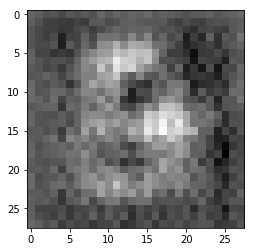

Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 1.0143... Generator Loss: 1.0319
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 0.9478
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.1350
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 1.6766


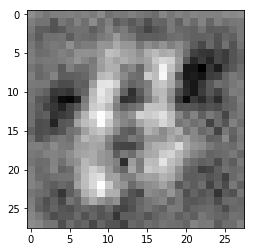

Epoch 1/2... Discriminator Loss: 0.8422... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.1183
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.4486
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 0.6153


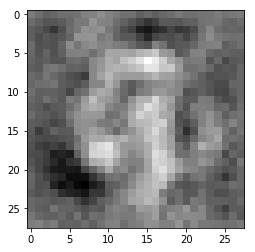

Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 1.6494
Epoch 1/2... Discriminator Loss: 0.7766... Generator Loss: 0.8152
Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.5779
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 2.8999
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 1.3203


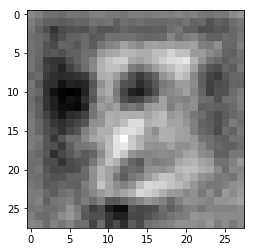

Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 1.3140
Epoch 1/2... Discriminator Loss: 0.9245... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 2.3778
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 1.1474


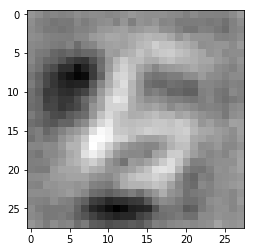

Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 2.1080
Epoch 2/2... Discriminator Loss: 0.7119... Generator Loss: 1.4998
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.5158
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.6815
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.2508


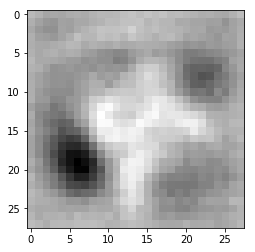

Epoch 2/2... Discriminator Loss: 0.7024... Generator Loss: 1.2864
Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 0.5198
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.6822
Epoch 2/2... Discriminator Loss: 1.2471... Generator Loss: 0.4447


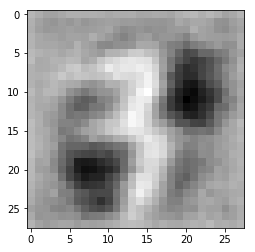

Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.2896
Epoch 2/2... Discriminator Loss: 0.7922... Generator Loss: 1.6898
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.4153
Epoch 2/2... Discriminator Loss: 0.8971... Generator Loss: 0.7328
Epoch 2/2... Discriminator Loss: 0.6824... Generator Loss: 1.2480


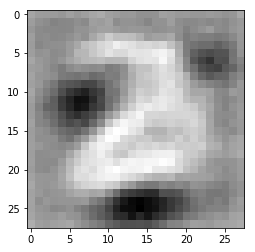

Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 0.7825... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 1.1750
Epoch 2/2... Discriminator Loss: 0.6601... Generator Loss: 1.9202


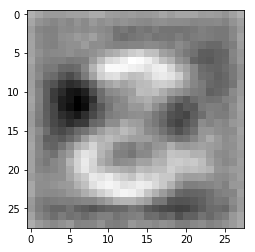

Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 0.8797


In [57]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.6410... Generator Loss: 1.1932
Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 1.2877
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 5.2133
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 0.7739


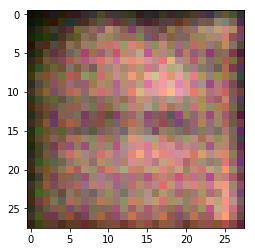

Epoch 1/2... Discriminator Loss: 0.6904... Generator Loss: 4.0693
Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.7803
Epoch 1/2... Discriminator Loss: 0.7985... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 0.7997... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 1.5414


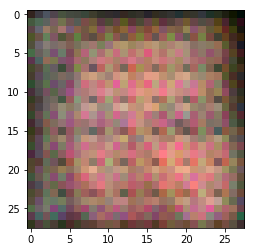

Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 3.7326
Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 2.4682
Epoch 1/2... Discriminator Loss: 0.5649... Generator Loss: 1.2646
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.5312


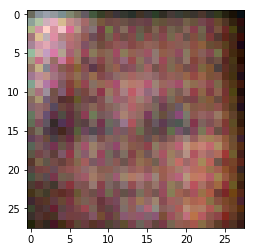

Epoch 1/2... Discriminator Loss: 0.4514... Generator Loss: 1.5577
Epoch 1/2... Discriminator Loss: 0.5811... Generator Loss: 1.9394
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.4659
Epoch 1/2... Discriminator Loss: 0.3295... Generator Loss: 3.3354
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.3706


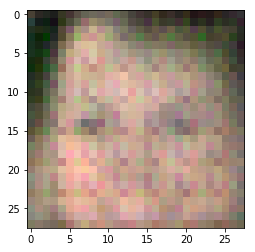

Epoch 1/2... Discriminator Loss: 0.3744... Generator Loss: 3.2198
Epoch 1/2... Discriminator Loss: 0.4313... Generator Loss: 3.3373
Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 2.7868
Epoch 1/2... Discriminator Loss: 0.5496... Generator Loss: 1.8687
Epoch 1/2... Discriminator Loss: 0.3680... Generator Loss: 2.4314


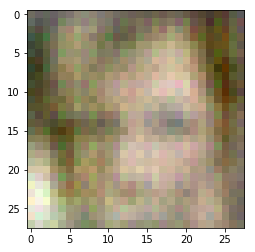

Epoch 1/2... Discriminator Loss: 0.5353... Generator Loss: 3.4983
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.3921
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 0.8767
Epoch 1/2... Discriminator Loss: 0.6709... Generator Loss: 1.1202


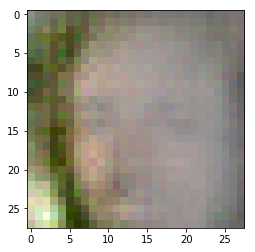

Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 1.2598
Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 1.8027
Epoch 1/2... Discriminator Loss: 0.0962... Generator Loss: 5.3965
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 1.2130
Epoch 1/2... Discriminator Loss: 0.4415... Generator Loss: 3.8070


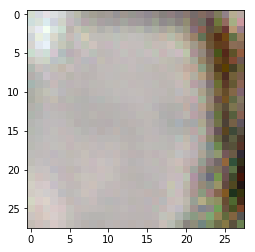

Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 3.1850
Epoch 1/2... Discriminator Loss: 0.4048... Generator Loss: 4.8376
Epoch 1/2... Discriminator Loss: 1.2949... Generator Loss: 0.3857
Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 1.3692
Epoch 1/2... Discriminator Loss: 0.8330... Generator Loss: 0.8652


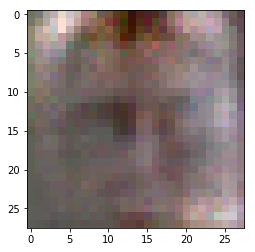

Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 1.9246
Epoch 1/2... Discriminator Loss: 0.6429... Generator Loss: 1.0154
Epoch 1/2... Discriminator Loss: 0.4365... Generator Loss: 1.3827
Epoch 1/2... Discriminator Loss: 2.2787... Generator Loss: 1.2795
Epoch 1/2... Discriminator Loss: 0.2535... Generator Loss: 2.1287


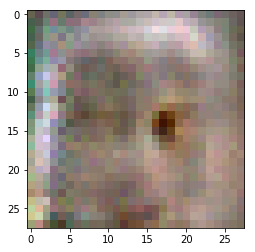

Epoch 1/2... Discriminator Loss: 0.3970... Generator Loss: 3.3571
Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 2.0363
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 1.4150
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 0.3857... Generator Loss: 2.2326


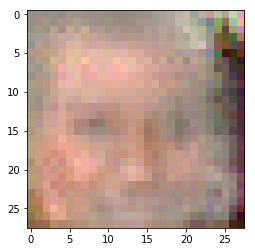

Epoch 1/2... Discriminator Loss: 0.4362... Generator Loss: 1.3726
Epoch 1/2... Discriminator Loss: 0.2536... Generator Loss: 2.2517
Epoch 1/2... Discriminator Loss: 0.1558... Generator Loss: 3.5572
Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 0.5845... Generator Loss: 1.5288


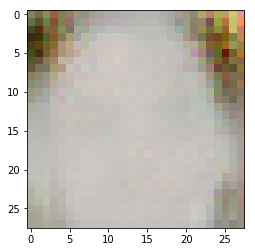

Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 1.1969
Epoch 1/2... Discriminator Loss: 0.1739... Generator Loss: 3.4721
Epoch 1/2... Discriminator Loss: 0.4128... Generator Loss: 1.3938
Epoch 1/2... Discriminator Loss: 0.2950... Generator Loss: 2.0159
Epoch 1/2... Discriminator Loss: 0.6054... Generator Loss: 0.9945


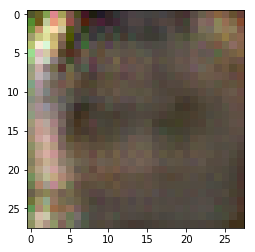

Epoch 1/2... Discriminator Loss: 0.4238... Generator Loss: 3.0395
Epoch 1/2... Discriminator Loss: 0.1416... Generator Loss: 3.8969
Epoch 1/2... Discriminator Loss: 0.1467... Generator Loss: 4.8481
Epoch 1/2... Discriminator Loss: 0.2812... Generator Loss: 3.0222
Epoch 1/2... Discriminator Loss: 0.2339... Generator Loss: 3.2060


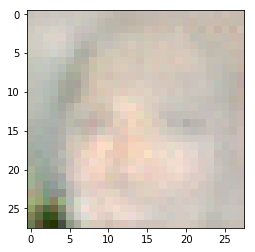

Epoch 1/2... Discriminator Loss: 0.1753... Generator Loss: 2.6818
Epoch 1/2... Discriminator Loss: 0.1456... Generator Loss: 3.2723
Epoch 1/2... Discriminator Loss: 0.3713... Generator Loss: 3.3884
Epoch 1/2... Discriminator Loss: 0.2842... Generator Loss: 2.0543
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 2.3733


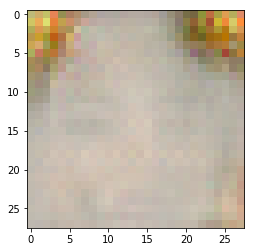

Epoch 1/2... Discriminator Loss: 0.4265... Generator Loss: 1.7850
Epoch 1/2... Discriminator Loss: 0.5573... Generator Loss: 1.2990
Epoch 1/2... Discriminator Loss: 0.1927... Generator Loss: 2.8519
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 1.0670
Epoch 1/2... Discriminator Loss: 0.1769... Generator Loss: 3.3174


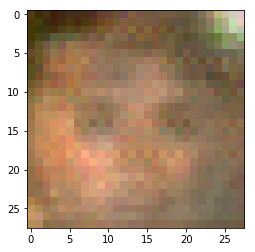

Epoch 1/2... Discriminator Loss: 0.4061... Generator Loss: 1.7797
Epoch 1/2... Discriminator Loss: 0.3880... Generator Loss: 1.8621
Epoch 1/2... Discriminator Loss: 0.1682... Generator Loss: 2.7102
Epoch 1/2... Discriminator Loss: 0.2233... Generator Loss: 3.1409
Epoch 2/2... Discriminator Loss: 0.1326... Generator Loss: 2.8183


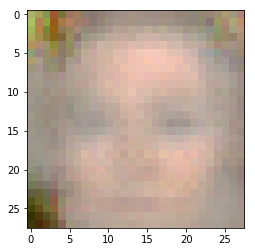

Epoch 2/2... Discriminator Loss: 0.4530... Generator Loss: 1.2989
Epoch 2/2... Discriminator Loss: 0.6361... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 0.8965... Generator Loss: 1.4723
Epoch 2/2... Discriminator Loss: 0.3866... Generator Loss: 1.8393
Epoch 2/2... Discriminator Loss: 0.2854... Generator Loss: 1.9206


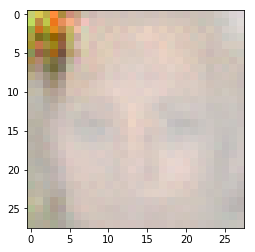

Epoch 2/2... Discriminator Loss: 0.4688... Generator Loss: 1.3723
Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 0.9155
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 1.8844
Epoch 2/2... Discriminator Loss: 0.1956... Generator Loss: 2.3524
Epoch 2/2... Discriminator Loss: 0.1770... Generator Loss: 2.8132


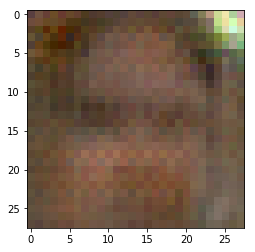

Epoch 2/2... Discriminator Loss: 0.2686... Generator Loss: 2.1200
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.2656
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 1.0913
Epoch 2/2... Discriminator Loss: 0.1224... Generator Loss: 4.0917
Epoch 2/2... Discriminator Loss: 0.7893... Generator Loss: 0.7755


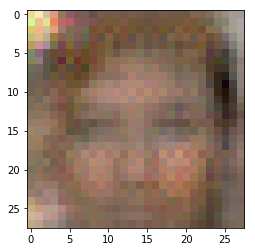

Epoch 2/2... Discriminator Loss: 2.0710... Generator Loss: 0.1722
Epoch 2/2... Discriminator Loss: 0.2016... Generator Loss: 5.2202
Epoch 2/2... Discriminator Loss: 0.3997... Generator Loss: 1.6060
Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 1.7182
Epoch 2/2... Discriminator Loss: 0.3112... Generator Loss: 2.7929


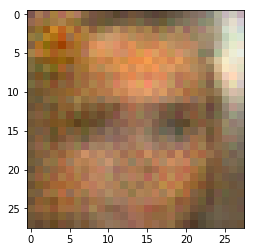

Epoch 2/2... Discriminator Loss: 0.3217... Generator Loss: 1.9189
Epoch 2/2... Discriminator Loss: 0.0862... Generator Loss: 4.7971
Epoch 2/2... Discriminator Loss: 0.2991... Generator Loss: 2.9004
Epoch 2/2... Discriminator Loss: 0.2227... Generator Loss: 3.0232
Epoch 2/2... Discriminator Loss: 0.2816... Generator Loss: 2.0119


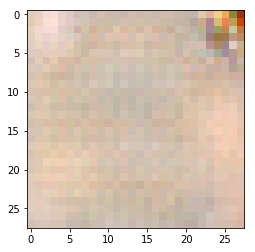

Epoch 2/2... Discriminator Loss: 0.0768... Generator Loss: 3.8352
Epoch 2/2... Discriminator Loss: 0.8701... Generator Loss: 1.5194
Epoch 2/2... Discriminator Loss: 0.6568... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 2.3603
Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 1.0679


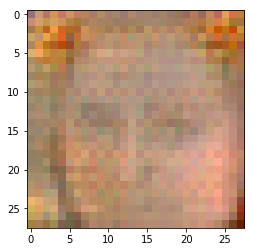

Epoch 2/2... Discriminator Loss: 0.3368... Generator Loss: 3.4038
Epoch 2/2... Discriminator Loss: 0.1286... Generator Loss: 3.3133
Epoch 2/2... Discriminator Loss: 0.1844... Generator Loss: 2.4402
Epoch 2/2... Discriminator Loss: 0.2004... Generator Loss: 2.9740
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 0.5764


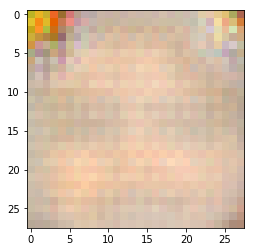

Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 0.3661... Generator Loss: 1.8445
Epoch 2/2... Discriminator Loss: 0.2532... Generator Loss: 5.0873
Epoch 2/2... Discriminator Loss: 0.2115... Generator Loss: 2.8148
Epoch 2/2... Discriminator Loss: 0.2599... Generator Loss: 2.6875


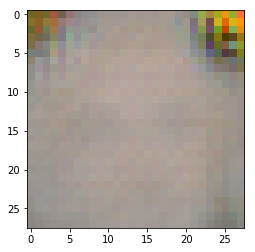

Epoch 2/2... Discriminator Loss: 0.4479... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 2.0166... Generator Loss: 0.2919
Epoch 2/2... Discriminator Loss: 0.3768... Generator Loss: 1.7463
Epoch 2/2... Discriminator Loss: 0.2459... Generator Loss: 4.5736
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 0.8871


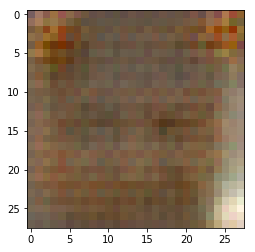

Epoch 2/2... Discriminator Loss: 0.3608... Generator Loss: 1.7845
Epoch 2/2... Discriminator Loss: 0.3035... Generator Loss: 1.8918
Epoch 2/2... Discriminator Loss: 1.0057... Generator Loss: 0.6512
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 1.8859
Epoch 2/2... Discriminator Loss: 0.2103... Generator Loss: 2.2425


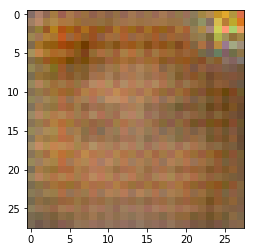

Epoch 2/2... Discriminator Loss: 0.2320... Generator Loss: 2.2015
Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 2.2719
Epoch 2/2... Discriminator Loss: 0.3975... Generator Loss: 1.5019
Epoch 2/2... Discriminator Loss: 0.2155... Generator Loss: 2.2450
Epoch 2/2... Discriminator Loss: 0.1064... Generator Loss: 3.2770


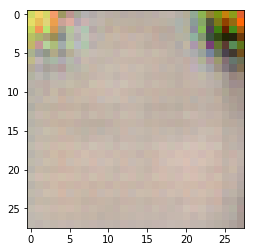

Epoch 2/2... Discriminator Loss: 0.0825... Generator Loss: 3.8190
Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 3.5010
Epoch 2/2... Discriminator Loss: 1.4909... Generator Loss: 0.3751
Epoch 2/2... Discriminator Loss: 0.2307... Generator Loss: 2.2285


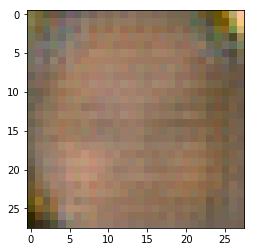

Epoch 2/2... Discriminator Loss: 0.1492... Generator Loss: 2.7060
Epoch 2/2... Discriminator Loss: 0.1465... Generator Loss: 2.6846
Epoch 2/2... Discriminator Loss: 0.0850... Generator Loss: 5.6258
Epoch 2/2... Discriminator Loss: 0.2277... Generator Loss: 2.1991
Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 1.7000


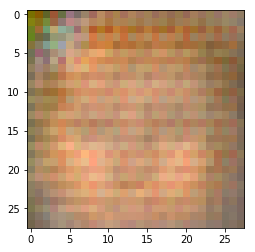

Epoch 2/2... Discriminator Loss: 0.5694... Generator Loss: 1.4397
Epoch 2/2... Discriminator Loss: 0.0825... Generator Loss: 4.8868
Epoch 2/2... Discriminator Loss: 1.5627... Generator Loss: 0.3318
Epoch 2/2... Discriminator Loss: 0.5411... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 0.3932... Generator Loss: 1.5511


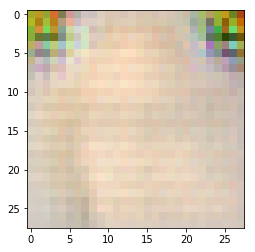

Epoch 2/2... Discriminator Loss: 0.1176... Generator Loss: 3.4114
Epoch 2/2... Discriminator Loss: 0.2657... Generator Loss: 1.9368
Epoch 2/2... Discriminator Loss: 0.3505... Generator Loss: 1.8032
Epoch 2/2... Discriminator Loss: 0.0727... Generator Loss: 4.4441
Epoch 2/2... Discriminator Loss: 0.0847... Generator Loss: 3.7057


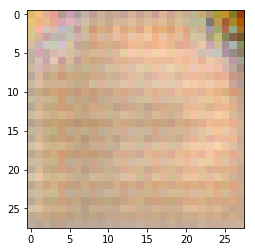

Epoch 2/2... Discriminator Loss: 0.1742... Generator Loss: 3.7747
Epoch 2/2... Discriminator Loss: 0.5155... Generator Loss: 1.1673
Epoch 2/2... Discriminator Loss: 0.5579... Generator Loss: 1.0912


In [59]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.